In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

In [3]:
DATADIR = '/gdrive/My Drive/Kidney Cancer'
CATEGORIES = ["Normal", "Tumor"]

In [4]:
IMG_SIZE = 100

In [5]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

In [6]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  10000


In [7]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [ ]:
# %70 %30 bloğu

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [9]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
import tensorflow as tf

train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=2)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=2)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [11]:
res = tf.keras.applications.ResNet50V2(
    input_shape=(100, 100, 3),
    include_top = False
)

res.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

res_model = Sequential()

res_model.add(res)
res_model.add(Dropout(0.4))
res_model.add(MaxPooling2D())
res_model.add(Flatten())
res_model.add(Dense(1024, activation='relu'))
res_model.add(BatchNormalization())
res_model.add(Dropout(0.4))
res_model.add(Dense(2, activation='softmax'))

res_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
res_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 4, 2048)        23564800  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 2048)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                         

In [13]:
from tensorflow import keras

callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=3)
]

In [ ]:
history = res_model.fit(x_train, train_yCl,
                    batch_size=128,
                    validation_data = (x_val, valid_yCl),
                    callbacks = callback_list,
                    epochs = 20
                    )

Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8736
Epoch 1: val_accuracy improved from -inf to 0.93500, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 [==============================] - 370s 6s/step - loss: 0.3675 - accuracy: 0.8736 - val_loss: 0.1687 - val_accuracy: 0.9350
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9531
Epoch 2: val_accuracy did not improve from 0.93500
57/57 [==============================] - 375s 7s/step - loss: 0.1360 - accuracy: 0.9531 - val_loss: 0.2149 - val_accuracy: 0.8888
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 0.1179 - accuracy: 0.9547
Epoch 3: val_accuracy did not improve from 0.93500
57/57 [==============================] - 367s 6s/step - loss: 0.1179 - accuracy: 0.9547 - val_loss: 0.1771 - val_accuracy: 0.9162
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9676
Epoch 4: val_accuracy improved from 0.93500 to 0.97375, saving model to model.h5
57/57 [==============================] - 371s 7s/step - loss: 0.0873 - accuracy: 0.9676 - val_loss: 0.0730 - val_accuracy: 0.9737
Epoch 5/20
57/5

In [ ]:
score_train_res = res_model.evaluate(x_train, train_yCl)
print("Train Accuracy: ", score_train_res[1])

score_test_res = res_model.evaluate(x_test, test_yCl)
print("Test Accuracy: ", score_test_res[1])

score_val_res = res_model.evaluate(x_val, valid_yCl)
print("Validation Accuracy: ", score_val_res[1])

225/225 [==============================] - 6s 28ms/step - loss: 0.0280 - accuracy: 0.9915
Train Accuracy:  0.991527795791626
63/63 [==============================] - 2s 29ms/step - loss: 0.0507 - accuracy: 0.9815
Test Accuracy:  0.9815000295639038
25/25 [==============================] - 1s 28ms/step - loss: 0.0426 - accuracy: 0.9850
Validation Accuracy:  0.9850000143051147


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

63/63 [==============================] - 2s 26ms/step
Accuracy: 0.5245
Precision: 1.0
Recall: 0.5245
F1-Score: 0.6880944571990817
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.52      0.69      2000
           1       0.00      0.00      0.00         0

    accuracy                           0.52      2000
   macro avg       0.50      0.26      0.34      2000
weighted avg       1.00      0.52      0.69      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


63/63 [==============================] - 2s 25ms/step


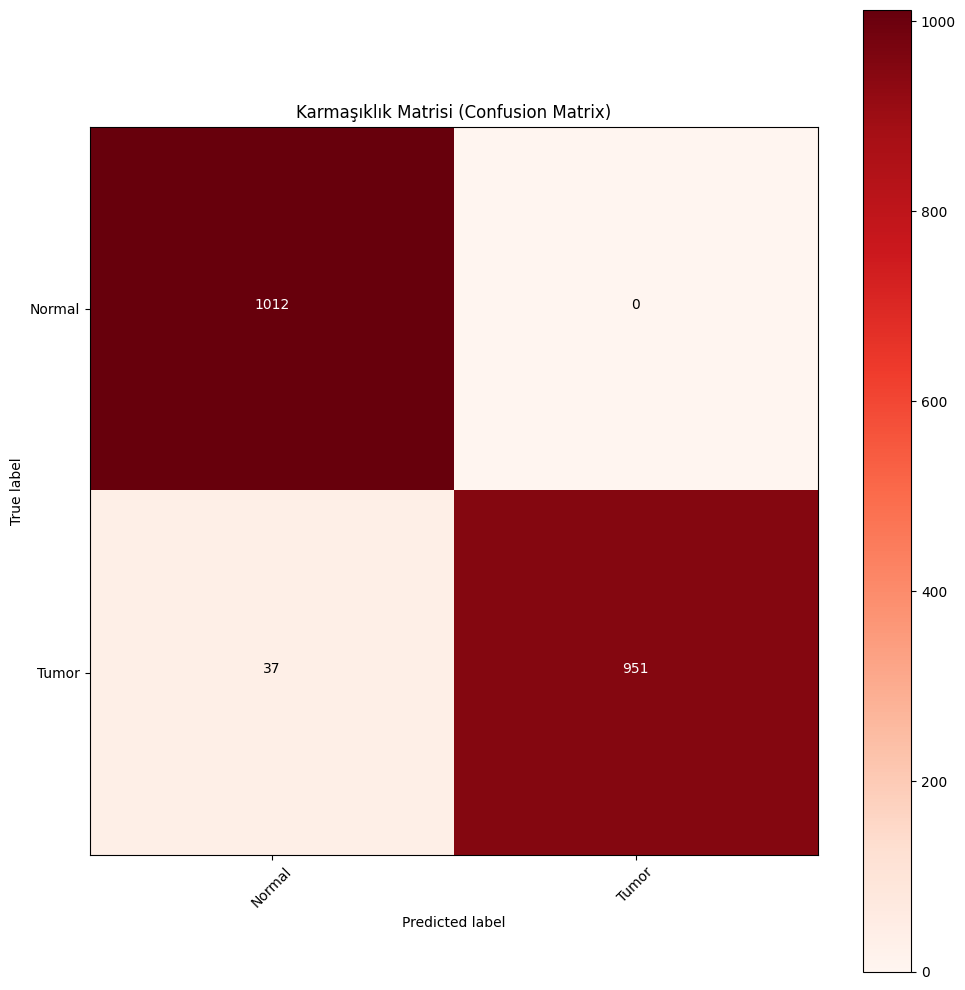

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_model(res_model, x_test, y_test):
    # Accuracy Score
    y_pred = res_model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test.reshape(-1 ,1) , axis=1)
    # y_test_classes = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    print(f"Accuracy: {accuracy}")

    # Precision Score
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted', zero_division = 0)
    print(f"Precision: {precision}")

    # Recall Score
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted', zero_division = 0)
    print(f"Recall: {recall}")

    # F1 Score
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted', zero_division = 0)
    print(f"F1-Score: {f1}")

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test_classes, y_pred_classes))

    #  Confusion Matrix
    Y_pred = res_model.predict(x_test)
    y_pred_model = np.argmax(Y_pred, axis=1)
    cm_model = confusion_matrix(y_test, y_pred_model)
    plot_confusion_matrix(cm_model, classes, normalize=False, title='Karmaşıklık Matrisi (Confusion Matrix)')

# Modeli değerlendir
evaluate_model(res_model, x_test, y_test)